# DATA512 Homework 1
## Reproducibility
The goal of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for rare disease from English Wikipedia from July 1, 2015 thorugh September 30, 2024.

We are expected to not only collect the data using the Wikipedia API and analyze the data, but make it so our process is reproducible.

## License
This code was developed by Sarah Nguyen for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [MIT License](https://chatgpt.com/c/67048ab0-3d24-8001-88ce-c354bb934b32#:~:text=under%20the%20MIT-,License,-.).

# Step 1: Data Acquistion
In the below section, we will import necessary libraries and data.
The data was collected from the Wikimedia Analytics API. [Documentation](https://doc.wikimedia.org/generated-data-platform/aqs/analytics-api/reference/page-views.html) for Pageview API call will provide additonal information on how to acess desktop, mobile web, and mobile app traffic data.

We are analyzing pageviews of Wikipedia's rare diseases from July 1, 2015 - September 30, 2024. This subset of rare diseases was colleted by iusing a rare diseases databse maintained by the [National Organization for Rare Diseases (NORD)](https://docs.google.com/document/d/1ovpmb9BXWrDVP1a-AKrT0E36XZC7N4n8-0iUfgQzKVg/edit?pli=1#:~:text=Help-,National%20Organization%20for%20Rare%20Disorders,-rarediseases.org) and matching them to Wikipedia articles that are either about a rare disease or have a section that mentions a rare disease.

We will be pulling a timeseries of only monthly activity for **user** pageview requests.


### Importing Libraries

In [17]:
import json, time, urllib.parse
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, ScalarFormatter, FuncFormatter, LogLocator

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Data In
Data csv can be found here: [rare-disease_cleaned.AUG.2024.csv](https://drive.google.com/file/d/15_FiKhBgXB2Ch9c0gAGYzKjF0DBhEPlY/view?usp=drive_link)

In [ ]:
# Reads in csv from the data in using the Wikipedia rare diseases subset of pages
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rare-disease_cleaned.AUG.2024.csv')

### Create List of Diseases

In [ ]:
# Creates a list of diseases from the csv so we can loop through all diseases
if 'disease' in data.columns:
    disease_list = data['disease'].unique().tolist()

    print(disease_list)

['Klinefelter syndrome', 'Aarskog–Scott syndrome', 'Abetalipoproteinemia', 'MT-TP', 'Ablepharon macrostomia syndrome', 'Acanthocheilonemiasis', 'Acanthosis nigricans', 'Aceruloplasminemia', 'Megaesophagus', 'Achard–Thiers syndrome', 'Achondrogenesis', 'Achondroplasia', 'Dwarfism', 'Osteochondrodysplasia', 'Fibroblast growth factor receptor 3', 'Vestibular schwannoma', 'Brain tumor', 'Acquired generalized lipodystrophy', 'Barraquer–Simons syndrome', 'Acrodermatitis enteropathica', 'Zinc deficiency', 'Brown-Séquard syndrome', 'Spinal cord injury', 'Brucellosis', 'Yellowstone Park bison herd', 'Māui dolphin', 'Brugada syndrome', 'Nav1.8', 'Sports cardiology', 'Budd–Chiari syndrome', 'Thrombosis', 'Hepatic veno-occlusive disease', 'Thromboangiitis obliterans', 'Bullous pemphigoid', 'Pemphigoid', 'Trigonocephaly', 'CADASIL', 'Campomelic dysplasia', 'Camurati–Engelmann disease', 'Canavan disease', 'Spongy degeneration of the central nervous system', 'Candidiasis', 'Breastfeeding difficulties

### Wikipedia API Code Example
This example illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). This example shows how to request monthly counts of page views for one specific article. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.
### License
This code block was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024

In [ ]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = disease_list

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2024093000"    # this is likely the wrong end date
}


### Attribution - API Request Template
This code block was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program.
Here is info from his original code block:

"The API request is made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title."

This current code block includes modifications by Sarah Nguyen, specifically:
- Adding the `platform = None` argument to the `request_pageviews_per_article` to handle different access types (desktop, mobile-web, mobile-app) dynamically.
- Modifying the reqest structure to include `request_template['access'] = platform`, making the API request reusable for different platofroms by paraneteruzubg the platform type.



In [ ]:
#########
#
#    PROCEDURES/FUNCTIONS
#

# request_pageviews_per_article modified to include "platform = None" in arguments
def request_pageviews_per_article(article_title = None,
                                  platform = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded

    request_template['access'] = platform

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


# **Collect Pageviews for Multiple Access Types**
This section of the code collects pageview data for rare disease articles across multiple platforms (desktop, mobile-web, and mobile-app) using the REST API. The data is organized by article title and platofrm, then saved into separate JSON files for each platform.

 ### Collecting Pageview Data:

The `collect_pageviews` function takes an article title and platform as inputs. It uses urllib.parse.quote to encode the article title and requests the pageview data from the REST API using the function request_pageviews_per_article (originally developed by Dr. McDonald).
If successful, the function returns the JSON response containing pageview data for the given article and platform. If the request fails, it prints an error message.

Data Processing:

For each article in the list `ARTICLE_TITLES`, the script retrieves pageview data for all three platforms (desktop, mobile-web, mobile-app). It checks if the response contains valid data and, if so, appends it to the corresponding platform list in the pageview_data dictionary.
In case of missing data or API issues, the script logs the error and continues with the next platform or article.
Saving the Data:

The collected pageview data is saved in separate JSON files for each platform (desktop, mobile-web, and mobile-app).

### Files Outputted from this Code Block:
#### Intermediary files:
- `rare-disease_pageviews_mobile-web_201507-202409.json`
- `rare-disease_pageviews_mobile-app_201507-202409.json`

#### Final files:
- `rare-disease_pageviews_desktop_201507-202409.json`

In [ ]:
# Creates a dictionary to store the pageview data for each article
pageview_data = {}

def collect_pageviews(title, platform):
    """
    Collect pageview data for a given article and platform by making an API request.

    Parameters:
    - title (str): The title of the article for which pageviews are to be collected.
    - platform (str): The platform from which to collect the pageviews. This can be one of "desktop", "mobile-web", or "mobile-app".

    Returns:
    - dict: The JSON response from the API containing pageview data if successful.
    - None: If there is an error during the API request.

    This function makes an API call to Wikimedia to retrieve the pageview data for a specific
    article and platform. If the request fails, it catches the exception and prints an error message.
    """

    # API request for the given platform (desktop, mobile-web, or mobile-app) with encoded URL
    articletitle_encoded = urllib.parse.quote(title.replace(' ', '_'), safe='')
    return request_pageviews_per_article(title, platform)


# For each disease, collect the pageview data for all access types
for idx, title in enumerate(ARTICLE_TITLES):
    print(f"Getting pageview data for {idx+1}/{len(ARTICLE_TITLES)}: {title}")

    if title not in pageview_data:
        pageview_data[title] = {
            "desktop": [],
            "mobile-web": [],
            "mobile-app": []
        }
    # Put data in requested format
    for platform in ["desktop", "mobile-web", "mobile-app"]:
        try:
            platform_views = collect_pageviews(title, platform)
            if platform_views and 'items' in platform_views:
                for month in platform_views['items']:
                    # Append the monthly data under the respective article and platform
                    pageview_data[title][platform].append({
                        "project": month["project"],
                        "granularity": month["granularity"],
                        "timestamp": month["timestamp"],
                        "agent": month["agent"],
                        "views": month["views"]
                    })
            else:
                # Handle missing data, couldn't get the encoding to work so have it handled here
                print(f"Could not retrieve data for '{title}' on {platform}")

        except Exception as e:
            # Any additional unexpected errors like issues w API request are caught here
            print(f"Error retrieving pageviews for '{title}' on {platform}: {str(e)}")
            continue  # Continue with the next platform or article

file_paths = {
    "desktop": "/content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_desktop.json",
    "mobile-web": "/content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_mobile-web.json",
    "mobile-app": "/content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_mobile-app.json"
}

# Save data for each platform into the three required JSON files
for platform, file_path in file_paths.items():
    # Extract data for the current platform across all articles
    platform_data = {title: data[platform] for title, data in pageview_data.items() if data[platform]}

    with open(file_path, 'w') as f:
        json.dump(platform_data, f, indent=4)
    print(f"Saved {platform} data to {file_path}")


Getting pageview data for 1/1773: Klinefelter syndrome
Getting pageview data for 2/1773: Aarskog–Scott syndrome
Getting pageview data for 3/1773: Abetalipoproteinemia
Getting pageview data for 4/1773: MT-TP
Getting pageview data for 5/1773: Ablepharon macrostomia syndrome
Getting pageview data for 6/1773: Acanthocheilonemiasis
Getting pageview data for 7/1773: Acanthosis nigricans
Getting pageview data for 8/1773: Aceruloplasminemia
Getting pageview data for 9/1773: Megaesophagus
Getting pageview data for 10/1773: Achard–Thiers syndrome
Getting pageview data for 11/1773: Achondrogenesis
Getting pageview data for 12/1773: Achondroplasia
Getting pageview data for 13/1773: Dwarfism
Getting pageview data for 14/1773: Osteochondrodysplasia
Getting pageview data for 15/1773: Fibroblast growth factor receptor 3
Getting pageview data for 16/1773: Vestibular schwannoma
Getting pageview data for 17/1773: Brain tumor
Getting pageview data for 18/1773: Acquired generalized lipodystrophy
Getting pa

# **Combine Json Objects**
This section combines json objects on disease and month.
I used this for the combining of mobile-app and mobile-web as we had two requests for the mobile type. Once I had all views from mobile, and desktop views, I used this same function to combine these two to get total views per rare disease.
First we load the data, then we combine the json objects and files.

`load_data` is a function that opens the file path for a list of file paths

`combine_json_objects` is a function to combine pageview data across JSON files based on article (disease) and timestamp.

`combine_files` is a function to combine data from multiple files and save the result


In [2]:
def load_data(file_paths):
    """
    Load JSON data from a list of file paths.

    Parameters:
    - file_paths (list of str): A list of file paths from which JSON data should be loaded.

    Returns:
    - data_list (list of dict): A list of JSON objects loaded from the given file paths.

    This function reads data from multiple JSON files and returns them as a list of dictionaries.
    Each dictionary corresponds to a single file's content.
    """
    return [json.load(open(file_path, 'r')) for file_path in file_paths]

In [ ]:
def combine_json_objects(*json_data_list):
    """
    Combine pageview data across multiple JSON datasets based on article title (disease) and timestamp.

    Parameters:
    - *json_data_list (list of dict): A variable number of JSON datasets, each containing pageview data with the structure:
        {disease (str): [{record}, {record}, ...], ...}
      Each record is expected to have a 'timestamp' and 'views' field.

    Returns:
    - combined_views (dict): A dictionary with combined pageview data for each article (disease).
      The views are summed across datasets for matching timestamps.

    This function combines multiple datasets by iterating over the records for each disease.
    It uses a lookup dictionary to sum the views if a record with the same timestamp already exists.
    """
    combined_views = {}

    # Loop through each dataset passed
    for json_data in json_data_list:
        for disease, records in json_data.items():  # Loop through each article title
            if disease not in combined_views:
                combined_views[disease] = []

            # Create a lookup dictionary to check for existing timestamps
            timestamp_lookup = {record['timestamp']: record for record in combined_views[disease]}

            # Loop through the records for the disease
            for record in records:
                timestamp = record['timestamp']

                if timestamp in timestamp_lookup:
                    # If the timestamp already exists, sum the views
                    timestamp_lookup[timestamp]['views'] += record['views']
                else:
                    # Otherwise, add the new record
                    combined_views[disease].append(record)

    # Return the combined dictionary with each article title as the key
    return combined_views

def combine_files(output_filename, *file_paths):
    """
    Combine data from multiple JSON files and save the result to a new file.

    Parameters:
    - output_filename (str): The path of the output file where the combined data will be saved.
    - *file_paths (list of str): A variable number of file paths to JSON files that should be combined.

    Returns:
    - None: The function saves the combined data to the specified file.

    This function loads JSON data from the given file paths, combines the data using the
    `combine_json_objects` function, and writes the result to the specified output file.
    """

    # Load data from the provided file paths
    data_list = load_data(file_paths)

    # Combine the data across files
    cumulative_data = combine_json_objects(*data_list)

    # Save the cumulative data to the output file
    with open(output_filename, 'w') as f:
        json.dump(cumulative_data, f, indent=4)
    print(f"Saved combined data to {output_filename}")

# Combining mobile-web and mobile-app
combined_mobile_filename = "/content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_mobile_combined.json"
combine_files(combined_mobile_filename, file_paths['mobile-web'], file_paths['mobile-app'])

# Creating a cumulative file combining all mobile access and desktop
cumulative_filename = "/content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_cumulative.json"
combine_files(cumulative_filename, combined_mobile_filename, file_paths['desktop'])


Saved combined data to /content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_mobile_combined.json
Saved combined data to /content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_cumulative.json


# Step 2: Analysis and Plot Set Up
Now that we have collected the data, we will conduct a basic visual analysis. We are graphing specific subsets of the data as a time series to produce three different graphs.

I have designed some helper functions as the data, plot set up, and saving function will be used by three graphs. The helper functions are listed below.

`json_to_df` is a function to convert JSON data to Pandas DataFrame which makes it easier for data manipulation

`setup_plot` is designed to be a helper function for setting up the plot since they all use the same axis

`save_plot` is a function that saves and shows the plot

GPT-4 was used to generate the function `setup_plot`. I prompted GPT with my own code for the three plots and asked it to create a function that could simplify the setup process to make it reusable as they all use the same axis and layout.


In [37]:
def json_to_df(data):
    """
    Convert JSON data into a Pandas DataFrame.

    Parameters:
    - data (dict): A dictionary containing article pageview data with structure:
        {article_title (str): [{timestamp (str), views (int)}, ...], ...}

    Returns:
    - df (pd.DataFrame): A Pandas DataFrame with columns 'article', 'timestamp', and 'views'.
      The 'timestamp' column is converted into a Pandas datetime object for easier plotting and analysis.

    This function loops through each article and its corresponding records, appending each
    record (article title, timestamp, views) to a list. This list is then converted into a DataFrame.
    """
    rows = []
    for article, records in data.items():
        for record in records:
            rows.append({
                "article": article,
                "timestamp": pd.to_datetime(record["timestamp"], format='%Y%m%d%H'),
                "views": record["views"]
            })
    return pd.DataFrame(rows)

# Load data
# file_paths_plot1 = [
#     "/content/drive/MyDrive/Colab Notebooks/rare-disease_desktop_201507_202409.json",
#     "/content/drive/MyDrive/Colab Notebooks/rare-disease_mobile_201507_202409.json"
# ]
file_paths_plot1 = [
    "/content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_desktop.json",
    "/content/drive/MyDrive/Colab Notebooks/NEWESTrare-disease_pageviews_mobile_combined.json"
]

desktop_data, mobile_data = load_data(file_paths_plot1)
desktop_df = json_to_df(desktop_data)
mobile_df = json_to_df(mobile_data)

In [47]:
def setup_plot(title, legend_loc="upper left", legend_outside=True, date_format='%b-%Y', log_scale=False):
    """
    Set up the plot configuration for displaying page views over time.

    Parameters:
    - title (str): The title of the plot.
    - legend_loc (str): The location of the legend inside the plot. Default is "upper left".
    - legend_outside (bool): Whether to place the legend outside the plot. Default is True.
    - date_format (str): The date format for the x-axis ticks. Default is '%Y-%m'.
    - log_scale (bool): Whether to use a logarithmic scale for the y-axis. Default is False.

    This function configures the plot settings, including x and y labels, title, x-axis tick
    intervals, and y-axis formatting. It also adjusts the legend placement either inside or outside
    the plot based on the 'legend_outside' argument. If 'log_scale' is True, it sets the y-axis to
    use a logarithmic scale.
    """

    plt.xlabel('Time')
    plt.ylabel('Page Views (Log-Scaled)')
    plt.title(title)

    # Set x-axis to show ticks every 6 months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # 6 months interval
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_format))  # Date format

    plt.xticks(rotation=45)

    if log_scale:
        plt.yscale('log')
        # Set ticks for powers of 10
        plt.gca().yaxis.set_minor_locator(LogLocator(base=10.0, subs=[1, 2, 5], numticks=10))  # Minor ticks at 1, 2, 5
        # Format large numbers with commas, no scientific notation
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))  # Format with commas

    # Set legend position based on the argument
    if legend_outside:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=legend_loc, borderaxespad=0.)  # Move legend outside the plot
    else:
        plt.legend(loc=legend_loc)

In [ ]:
def save_plot(file_path, bbox_inches='tight'):
    """
    Save the plot to a file and display it.

    Parameters:
    - file_path (str): The path where the plot should be saved.
    - bbox_inches (str): Specifies how to save the plot (default is 'tight' to ensure the entire plot is captured).

    This function saves the current plot to the given file path and then displays the plot.
    The 'bbox_inches' argument controls how tightly the bounding box around the plot is cropped.
    """
    plt.savefig(file_path, bbox_inches=bbox_inches)
    plt.show()

# Graph 1: Maximum Average and Minimum Average
The graph contains time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. Graph has four lines (max desktop, min desktop, max mobile, min mobile).

The graph is log scaled.



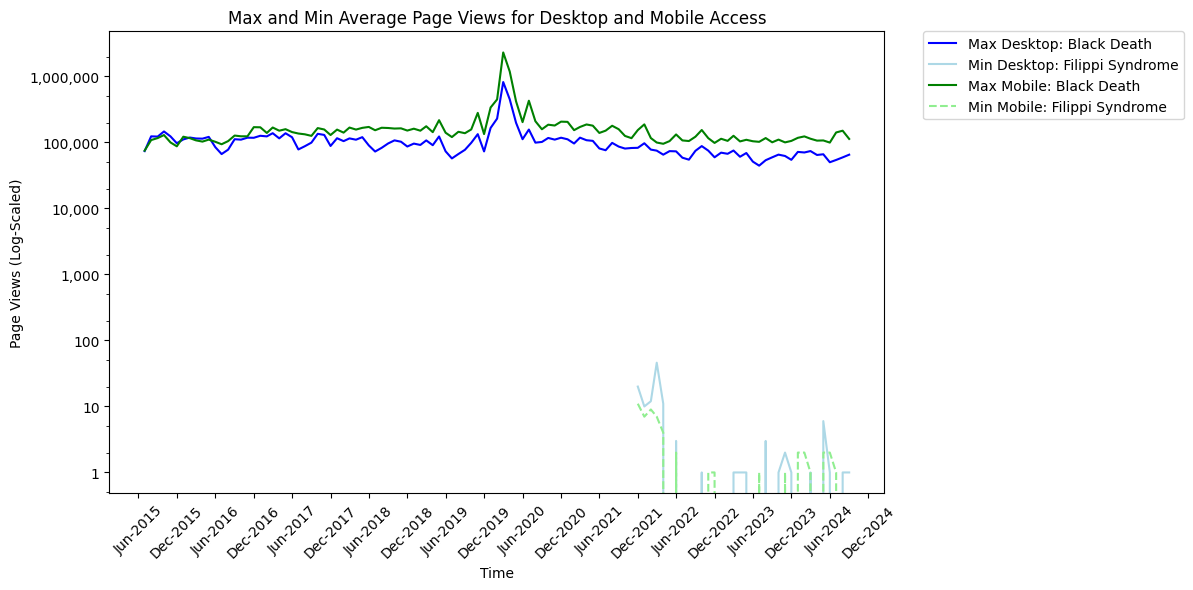

In [48]:
# Finds average views for desktop and mobile access using groupby
desktop_avg = desktop_df.groupby('article')['views'].mean()
mobile_avg = mobile_df.groupby('article')['views'].mean()

#  Highest and lowest average page requests
max_desktop = desktop_avg.idxmax()
min_desktop = desktop_avg.idxmin()

max_mobile = mobile_avg.idxmax()
min_mobile = mobile_avg.idxmin()

# Filter data for max & min articles
max_desktop_df = desktop_df[desktop_df['article'] == max_desktop]
min_desktop_df = desktop_df[desktop_df['article'] == min_desktop]

max_mobile_df = mobile_df[mobile_df['article'] == max_mobile]
min_mobile_df = mobile_df[mobile_df['article'] == min_mobile]

plt.figure(figsize=(10, 6))
plt.plot(max_desktop_df['timestamp'], max_desktop_df['views'], label=f'Max Desktop: {max_desktop}', color='blue')
plt.plot(min_desktop_df['timestamp'], min_desktop_df['views'], label=f'Min Desktop: {min_desktop}', color='lightblue')
plt.plot(max_mobile_df['timestamp'], max_mobile_df['views'], label=f'Max Mobile: {max_mobile}', color='green')
plt.plot(min_mobile_df['timestamp'], min_mobile_df['views'], label=f'Min Mobile: {min_mobile}', color='lightgreen', linestyle = 'dashed')

setup_plot('Max and Min Average Page Views for Desktop and Mobile Access', log_scale = True)
save_plot('/content/drive/MyDrive/Colab Notebooks/max_min_avg.png')


# Graph 2: Top 10 Peak Page Views

 The second graph contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. Created by first, finding the month for each article that contains the highest (peak) page views, The articles are order by highest these peak values. Graph contains the top 10 for desktop and top 10 for mobile access.
 Top 1 indicates it is the article with the largest pageviews.

 The graph is log scaled.

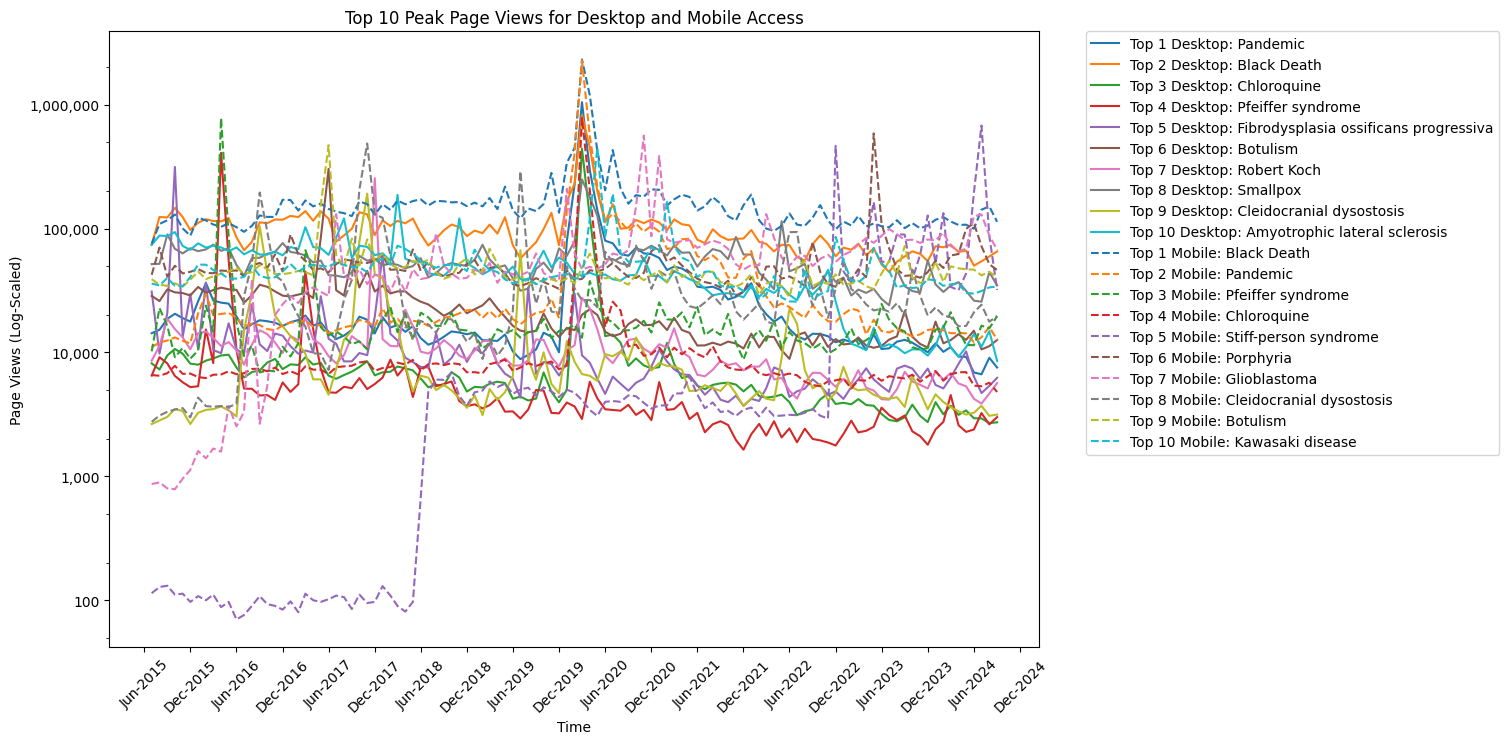

In [49]:
# Find highest peakviews for each article
desktop_peaks = desktop_df.groupby('article')['views'].max().reset_index()
mobile_peaks = mobile_df.groupby('article')['views'].max().reset_index()

# Sort by the highest peak views and select the top 10 articles
top_10_desktop = desktop_peaks.nlargest(10, 'views').reset_index(drop=True)
top_10_mobile = mobile_peaks.nlargest(10, 'views').reset_index(drop=True)

# Filter data for the top 10 articles based on peak views
desktop_top10_df = desktop_df[desktop_df['article'].isin(top_10_desktop['article'])]
mobile_top10_df = mobile_df[mobile_df['article'].isin(top_10_mobile['article'])]

plt.figure(figsize=(12, 8))

# Plot for top 10 desktop articles for desktop and mobile
for idx, article in enumerate(top_10_desktop['article']):
    article_data = desktop_top10_df[desktop_top10_df['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f'Top {idx+1} Desktop: {article}')

for idx, article in enumerate(top_10_mobile['article']):
    article_data = mobile_top10_df[mobile_top10_df['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f'Top {idx+1} Mobile: {article}', linestyle='--')

setup_plot('Top 10 Peak Page Views for Desktop and Mobile Access', legend_loc='upper left', log_scale = True)
save_plot('/content/drive/MyDrive/Colab Notebooks/top_10_peak.png')

# Graph 3: Fewest Months of Data

The third graph shows pages that have the fewest months of available data. The graph shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

The graph is log scaled.

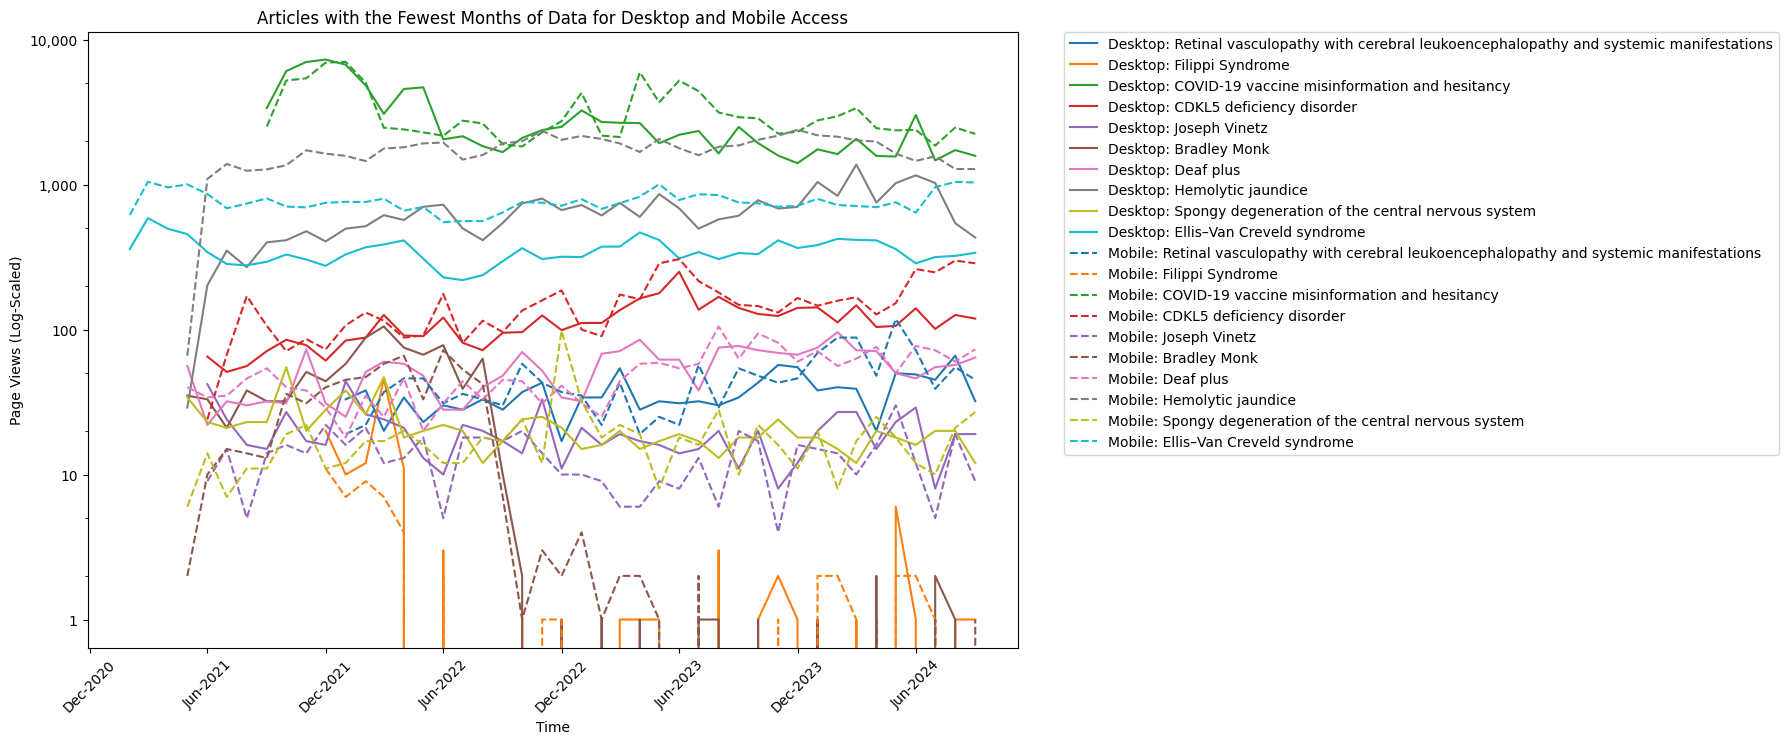

In [50]:
# Count the num of unique months for each article
desktop_months_count = desktop_df.groupby('article')['timestamp'].nunique().reset_index(name='num_months')
mobile_months_count = mobile_df.groupby('article')['timestamp'].nunique().reset_index(name='num_months')

# Sort by fewest number of months and select the top 10 articles
top_10_fewest_desktop = desktop_months_count.nsmallest(10, 'num_months')
top_10_fewest_mobile = mobile_months_count.nsmallest(10, 'num_months')

# Filter the df for the top 10 articles based on fewest months of data
desktop_fewest_df = desktop_df[desktop_df['article'].isin(top_10_fewest_desktop['article'])]
mobile_fewest_df = mobile_df[mobile_df['article'].isin(top_10_fewest_mobile['article'])]

# Plot time series for the top 10 articles with the fewest months of data
plt.figure(figsize=(12, 8))
for article in top_10_fewest_desktop['article']:
    article_data = desktop_fewest_df[desktop_fewest_df['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f'Desktop: {article}')

for article in top_10_fewest_mobile['article']:
    article_data = mobile_fewest_df[mobile_fewest_df['article'] == article]
    plt.plot(article_data['timestamp'], article_data['views'], label=f'Mobile: {article}', linestyle='--')

setup_plot('Articles with the Fewest Months of Data for Desktop and Mobile Access', legend_loc='upper left', log_scale = True)
save_plot('/content/drive/MyDrive/Colab Notebooks/fewest_months_of_data.png')